# Capstone Project: Generating Shakespearean Text with NLP and LSTM  

In this project, I will implement and train a language model using **Natural Language Processing (NLP)** and **Long Short-Term Memory (LSTM)** networks. The goal is to generate text in the style of Shakespeare by leveraging a corpus of **[Shakespearean Sonnets](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154)**.  

Through this process, I will explore sequence prediction techniques, text vectorization, and model training to create text that mimics Shakespeare's poetic style.

## N-gram Based LSTM: A Hybrid Approach to Language Modeling  

N-gram based LSTM combines traditional **N-gram language modeling** with the power of **Long Short-Term Memory (LSTM)** networks to improve text prediction and sequence modeling.  

### How It Works  
- **N-gram models** estimate word probabilities based on fixed-length sequences, making them efficient but limited in capturing long-range dependencies.  
- **LSTM networks**, on the other hand, excel at learning contextual relationships over longer sequences but require more computational resources.  
- By integrating LSTM into N-gram models, researchers aim to **smooth probability estimations** and enhance language modeling performance.  

### Key Advantages  
- **Improved Memory Depth**: LSTM helps extend the effective memory of N-gram models, making them more robust for longer sequences.  
- **Better Perplexity Scores**: Experiments show that LSTM-based N-gram models outperform traditional back-off estimators like Katz or Kneser-Ney for higher N values.  
- **Parallel Processing**: N-gram contexts can be processed efficiently in batches, making this approach practical for applications like **voice search** and **query-based language models**.  

While LSTM-based N-gram models offer significant improvements, they also introduce higher computational costs due to discarded context encodings. However, their ability to balance efficiency and accuracy makes them a promising approach for modern NLP tasks.  




In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

## Defining some useful global variables


- `FILE_PATH`: The file path where the sonnets file is located. 

- `NUM_BATCHES`: Number of batches. Defaults to 16.
- `LSTM_UNITS`: Number of LSTM units in the LSTM layer.
- `EMBEDDING_DIM`: Number of dimensions in the embedding layer.

In [2]:
FILE_PATH = './data/sonnets.txt'
NUM_BATCHES = 16
LSTM_UNITS = 192
EMBEDDING_DIM = 100

In [3]:
# Read the data
with open(FILE_PATH) as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## fit_vectorizer: Tokenizing and Transforming Text

This function utilizes the [tf.keras.layers.TextVectorization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) to convert text into numeric representations. It ensures preprocessing steps like punctuation removal and lowercase conversion while carefully managing sentence padding to enable n-gram construction.


In [4]:
def fit_vectorizer(corpus):
    """
    Instantiates the vectorizer class on the corpus
    
    Args:
        corpus (list): List with the sentences.
    
    Returns:
        (tf.keras.layers.TextVectorization): an instance of the TextVectorization class containing the word-index dictionary, adapted to the corpus sentences.
    """    

    tf.keras.utils.set_random_seed(32)


    # Define the object
    vectorizer = tf.keras.layers.TextVectorization(
        standardize='lower_and_strip_punctuation',
        ragged=True
    )
    
    # Adapt it to the corpus
    vectorizer.adapt(corpus)

    return vectorizer

In [5]:
vectorizer = fit_vectorizer(corpus)
total_words = len(vectorizer.get_vocabulary())
print(f"Total number of words in corpus (including the out of vocabulary): {total_words}")

Total number of words in corpus (including the out of vocabulary): 3189


## Understanding String Input vs. List Input in TextVectorization

The `vectorizer` can handle both single strings and lists of strings, but the output format depends on the input type. 

- If pass a **single string**, the output will be a standard *tensor*.
- If pass a **list of strings**, the output will be a *ragged tensor*—but only if the `TextVectorization` layer has been properly configured for this behavior.

This distinction is important when working with text preprocessing, as it affects how sequences are managed and transformed before model training.


In [6]:
print(f"Passing a string directly: {vectorizer('This is a test string').__repr__()}")
print(f"Passing a list of strings: {vectorizer(['This is a test string'])}")

Passing a string directly: <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  29,   14,   18,    1, 1679])>
Passing a list of strings: <tf.RaggedTensor [[29, 14, 18, 1, 1679]]>


## Implementing `n_gram_seqs`

This function takes my **fitted vectorizer** and my **corpus** (a list of sentences) and returns a list containing the generated n-gram sequences for each sentence.

### Important Considerations:
- Passing `vectorizer(sentence)` will result in a non-padded output.
- If I pass `vectorizer(list_of_sentences)`, padding will be skipped **only if** I set `ragged=True` in the `TextVectorization` setup.
- This step builds on the previous one, so any errors in my earlier processing may affect my results.

Once I’ve implemented this function, my model will be able to efficiently process text sequences and better predict the next word.


In [7]:
def n_gram_seqs(corpus, vectorizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        vectorizer (tf.keras.layers.TextVectorization): an instance of the TextVectorization class adapted in the corpus
    
    Returns:
        (list of tf.int64 tensors): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    for line in corpus:
        token_list = vectorizer(line)
        for i in range(2, len(token_list) + 1):
            input_sequences.append(token_list[:i])
    
    return input_sequences

In [8]:
# Test the function with one example
first_example_sequence = n_gram_seqs([corpus[0]], vectorizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 35, 489])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  35,  489, 1259])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  35,  489, 1259,  164])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230,  582])>]

In [9]:
# Test the function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], vectorizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([  9, 935])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  9, 935, 143])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  9, 935, 143, 369])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  9, 935, 143, 369, 101])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171, 207])>,
 <tf.Tensor: shape=(2,), dtype=int64, numpy=array([17, 23])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([17, 23,  3])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  17,   23,    3, 1006])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31,   51])>,
 <tf.Tensor: shape=(8,), dtype=int64, numpy=array([  17,   23,   

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [10]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, vectorizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15355
maximum length of sequences is: 11


## Padding Sequences with `pad_seqs`

The `pad_seqs` function to ensure that all given sequences are padded to the desired maximum length. This function takes a list of sequences and returns a **NumPy array** with the properly padded sequences.

To accomplish this, I can refer to the [`tf.keras.utils.pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) documentation for guidance.

### Important Considerations:
- I need to apply the correct padding method as discussed in the lecture.
- Proper padding ensures consistent sequence length, which is crucial for model training.


In [11]:
def pad_seqs(input_sequences, max_sequence_len):
    """
    Pads tokenized sequences to the same length
    
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    
    Returns:
        (np.array of int32): tokenized sequences padded to the same length
    """
    
    
    padded_sequences = tf.keras.utils.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

    return padded_sequences

In [12]:
# Test the function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[   0,    0,    0,    0,   35,  489],
       [   0,    0,    0,   35,  489, 1259],
       [   0,    0,   35,  489, 1259,  164],
       [   0,   35,  489, 1259,  164,  230],
       [  35,  489, 1259,  164,  230,  582]], dtype=int32)

In [13]:
# Test the function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[   0,    0,    0,    0,    0,    0,    9,  935],
       [   0,    0,    0,    0,    0,    9,  935,  143],
       [   0,    0,    0,    0,    9,  935,  143,  369],
       [   0,    0,    0,    9,  935,  143,  369,  101],
       [   0,    0,    9,  935,  143,  369,  101,  171],
       [   0,    9,  935,  143,  369,  101,  171,  207],
       [   0,    0,    0,    0,    0,    0,   17,   23],
       [   0,    0,    0,    0,    0,   17,   23,    3],
       [   0,    0,    0,    0,   17,   23,    3, 1006],
       [   0,    0,    0,   17,   23,    3, 1006,   64],
       [   0,    0,   17,   23,    3, 1006,   64,   31],
       [   0,   17,   23,    3, 1006,   64,   31,   51],
       [  17,   23,    3, 1006,   64,   31,   51,  803],
       [   0,    0,    0,    0,    0,    0,   27,  315],
       [   0,    0,    0,    0,    0,   27,  315,  745],
       [   0,    0,    0,    0,   27,  315,  745,  101],
       [   0,    0,    0,   27,  315,  745,  101,  209],
       [   0,    0,   27,  315,

In [14]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15355, 11)


## Preparing Features and Labels for Model Training

Before feeding the data into the neural network, I need to split it into **features** and **labels**. In this case:
- **Features** will be the *padded n-gram sequences* with the **last element removed**.
- **Labels** will be the words removed from these sequences.

### Implementing `features_and_labels_dataset`
Now, I will complete the `features_and_labels_dataset` function, which takes the `padded n-gram sequences` as input and returns a **batched** [TensorFlow dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). The dataset should contain elements in the form `(sentence, label)`.

### Important Considerations:
- This function also receives the **total number of words** in the corpus, which is essential for **one-hot encoding** the labels. I will use [`tf.keras.utils.to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) for this step.
- To create the dataset, I can use [`tf.data.Dataset.from_tensor_slices`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) after extracting sentences and their respective labels.
- To **batch** the dataset, I will call the method `.batch()`. A good batch size is `16`, but I can choose a different number as long as it does not exceed `64`, otherwise the model may require excessive epochs to achieve good accuracy.


In [15]:
def features_and_labels_dataset(input_sequences, total_words):
    """
    Generates features and labels from n-grams and returns a tensorflow dataset
    
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    
    Returns:
        (tf.data.Dataset): Dataset with elements in the form (sentence, label)
    """
    
    # Define the features and labels
    features = input_sequences[:, :-1]
    labels = input_sequences[:, -1]

    # One hot encode the labels
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

    # Build the dataset with the features and one hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((features, one_hot_labels))

    # Batch the dataset with number of batches given by the global variable
    batched_dataset = dataset.batch(NUM_BATCHES)

    return batched_dataset

In [16]:
# Test the function with the padded n_grams_seq of the first example
dataset_example = features_and_labels_dataset(first_padded_seq, total_words)

print("Example:\n")
for features, label in dataset_example.take(1):
    print(f"N grams:\n\n {features}\n")
    print(f"Label shape:\n\n {label.shape}")

Example:

N grams:

 [[   0    0    0    0   35]
 [   0    0    0   35  489]
 [   0    0   35  489 1259]
 [   0   35  489 1259  164]
 [  35  489 1259  164  230]]

Label shape:

 (5, 3189)


## Generating the Training Dataset

Now, I will generate the complete dataset needed for model training. To optimize performance, I will use the [`prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) method, which helps speed up the training process by preparing data in advance.


In [17]:
# Split the whole corpus
dataset = features_and_labels_dataset(input_sequences, total_words).prefetch(tf.data.AUTOTUNE)

print(f"Feature shape: {dataset.element_spec[0]}")
print(f"Label shape: {dataset.element_spec[1]}")

Feature shape: TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)
Label shape: TensorSpec(shape=(None, 3189), dtype=tf.float64, name=None)


## Designing the Model Architecture

Now, I will define a model capable of achieving **at least 80% accuracy**.

### Key Considerations:
- The first layer must be an [`Input`](https://www.tensorflow.org/api_docs/python/tf/keras/Input) layer with the correct parameters. Since my input consists of fixed-length vectors, I need to set the appropriate size—keeping in mind that the last element of each input has been removed to serve as the label.
- The `Embedding` layer should have an `output_dim` of **100**, which is already provided.
- A **Bidirectional LSTM** is particularly effective for this task.
- The final layer must contain the same number of units as the total words in the corpus and use a **softmax activation function**.
- **30 epochs** should be sufficient to surpass **80% accuracy**.

Once completed, this model will effectively learn and predict the next word in text sequences.


In [18]:
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model
    
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    
    Returns:
       (tf.keras Model): the text generator model
    """
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input(shape=(max_sequence_len-1,)))
    model.add(tf.keras.layers.Embedding(input_dim=total_words, output_dim=EMBEDDING_DIM))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNITS)))
    model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()

    return model

In [19]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 100)        │       318,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 384)            │       450,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3189)           │     1,227,765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,996,713 (7.62 MB)

 Trainable params: 1,996,713 (7.62 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Test the model with the dataset
# Get a batch of data
example_batch = dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Model is not compatible with the dataset was defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (16, 3189)


In [21]:
# Train the model
history = model.fit(dataset, epochs=30, verbose=1)

Epoch 1/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.0251 - loss: 7.0403
Epoch 2/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0291 - loss: 6.0920
Epoch 3/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0414 - loss: 5.6761
Epoch 4/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0524 - loss: 5.3354
Epoch 5/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0600 - loss: 5.2120
Epoch 6/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0693 - loss: 4.9089
Epoch 7/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0842 - loss: 4.6587
Epoch 8/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1052 - loss: 4.4461
Epoch 9/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1443 - loss: 4.1051
Epoch 10/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2132 - loss: 3.7044
Epoch 11/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2961 - loss: 3.2666
Epoch 12/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

## Design Target: Achieving 80% Training Accuracy

The model must reach **at least 80% training accuracy**. If this threshold is not met, adjustments to the architecture should be made, such as **retraining** with a different model configuration or **increasing the number of units** in the `LSTM` layer to enhance performance.


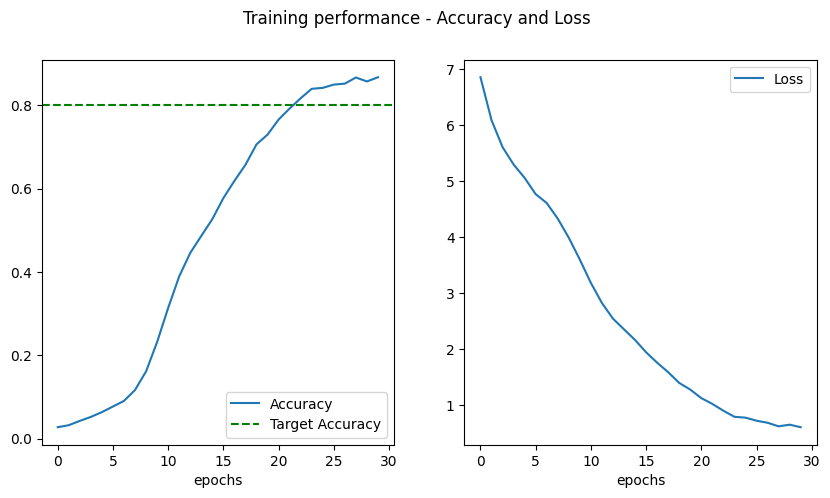

In [22]:
# Get training and validation accuracies
acc = history.history['accuracy']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training performance - Accuracy and Loss')

for i, (data, label) in enumerate(zip([acc,loss], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data, label=label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

# Add a horizontal line at 0.8 for the Accuracy plot
ax[0].axhline(y=0.8, color='green', linestyle='--', label='Target Accuracy')
ax[0].legend()


## Experiencing My Model in Action  

After all my hard work, it's finally time to see my model generate text!  

I’ll run the cell below and watch as my model predicts the next 100 words based on a seed text.  

This is my moment to watch my model bring words to life!  


In [23]:
seed_text = "How beautiful is the completion of my Capstone project"
next_words = 100
  
for _ in range(next_words):
    # Convert the text into sequences
    token_list = vectorizer(seed_text)
    # Pad the sequences
    token_list = tf.keras.utils.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict([token_list], verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = vectorizer.get_vocabulary()[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

How beautiful is the completion of my Capstone project held dwell on pride lie to spend that day am now i love blind blind am thy defect will thy blind say call thee still me to be blind beloved of thy mind prove spend up thee lie away to me i know not lost i blind do blind blind am thy mind thy will prove know to me hate prove blind blind blind forsworn do i blind blind forsworn to do blind blind do i love blind blind blind love thy blind will will not prove this blind do fawn blind view i do not so do i blind
